In [1]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random


# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop', 'two_up']

# image size
# IMG_SIZE = 64
# SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 1

2023-06-10 19:31:37.690987: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-10 19:31:38.402693: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-10 19:31:38.408021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 19:31:40.784075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMG_SIZE_EXPLORATION = [12, 28, 32, 64, 128, 256]
# mehr macht kein sinn weil wegen so groß kann das ja gar ned sein
# https://pubs.rsna.org/doi/full/10.1148/ryai.2019190015
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8700246/
# https://www.researchgate.net/post/Which_Image_resolution_should_I_use_for_training_for_deep_neural_network

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7655862509428285683
xla_global_id: -1
]


2023-06-10 19:31:45.437946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-10 19:31:45.908481: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
annotations = dict()

#PATH = '/media/martinaemmert/561F8ECA05FBCAB1/Week6/gesture_dataset_sample'
PATH = '../../gesture_dataset_sample'
for condition in CONDITIONS:
    with open(f'{PATH}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

hier abhängige funktionen dann

In [5]:
def preprocess_image(img, size):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, (size, size))
    return img_resized

In [6]:
def load_data(size):
    images = [] # stores actual image data
    labels = [] # stores labels (as integer - because this is what our network needs)
    label_names = [] # maps label ints to their actual categories so we can understand predictions later

    # loop over all conditions
    # loop over all files in the condition's directory
    # read the image and corresponding annotation
    # crop image to the region of interest
    # preprocess image
    # store preprocessed image and label in corresponding lists
    for condition in CONDITIONS:
        for filename in os.listdir(f'{PATH}/{condition}'):
            # extract unique ID from file name
            UID = filename.split('.')[0]
            img = cv2.imread(f'{PATH}/{condition}/{filename}')
            
            # get annotation from the dict we loaded earlier
            try:
                annotation = annotations[condition][UID]
            except Exception as e:
                print(e)
                continue
            
            # iterate over all hands annotated in the image
            for i, bbox in enumerate(annotation['bboxes']):
                # annotated bounding boxes are in the range from 0 to 1
                # therefore we have to scale them to the image size
                x1 = int(bbox[0] * img.shape[1])
                y1 = int(bbox[1] * img.shape[0])
                w = int(bbox[2] * img.shape[1])
                h = int(bbox[3] * img.shape[0])
                x2 = x1 + w
                y2 = y1 + h
                
                # crop image to the bounding box and apply pre-processing
                crop = img[y1:y2, x1:x2]
                preprocessed = preprocess_image(crop, size)
                
                # get the annotated hand's label
                # if we have not seen this label yet, add it to the list of labels
                label = annotation['labels'][i]
                if label not in label_names:
                    label_names.append(label)
                
                label_index = label_names.index(label)
                
                images.append(preprocessed)
                labels.append(label_index)
    return images, labels, label_names

In [7]:
def prepare_train_test(images, labels, size):
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    X_train = np.array(X_train).astype('float32')
    X_train = X_train / 255.

    X_test = np.array(X_test).astype('float32')
    X_test = X_test / 255.

    y_train_one_hot = to_categorical(y_train)
    y_test_one_hot = to_categorical(y_test)

    train_label = y_train_one_hot
    test_label = y_test_one_hot

    X_train = X_train.reshape(-1, size, size, COLOR_CHANNELS)
    X_test = X_test.reshape(-1, size, size, COLOR_CHANNELS)
    return X_train, train_label, X_test, test_label

In [8]:
def build_model(label_names, size):
    # variables for hyperparameters
    batch_size = 8
    epochs = 50

    num_classes = len(label_names)
    activation = 'relu'
    activation_conv = 'LeakyReLU'  # LeakyReLU
    layer_count = 2
    num_neurons = 64

    # define model structure
    # with keras, we can use a model's add() function to add layers to the network one by one
    model = Sequential()

    # data augmentation (this can also be done beforehand - but don't augment the test dataset!)
    #model.add(RandomFlip('horizontal'))
    #model.add(RandomContrast(0.1))
    #model.add(RandomBrightness(0.1))
    #model.add(RandomRotation(0.2))

    # first, we add some convolution layers followed by max pooling
    model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(size, size, COLOR_CHANNELS), padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

    model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

    model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # dropout layers can drop part of the data during each epoch - this prevents overfitting
    model.add(Dropout(0.2))

    # after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
    model.add(Flatten())

    # add some fully connected layers ("Dense")
    for i in range(layer_count - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(num_neurons, activation=activation))

    # for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
    model.add(Dense(num_classes, activation='softmax'))

    # specify loss function, optimizer and evaluation metrics
    # for classification, categorial crossentropy is used as a loss function
    # use the adam optimizer unless you have a good reason not to
    model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

    # define callback functions that react to the model's behavior during training
    # in this example, we reduce the learning rate once we get stuck and early stopping
    # to cancel the training if there are no improvements for a certain amount of epochs
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)

    # model_params = dict()
    # model_params['batch_size'] = batch_size
    # model_params['epochs'] = epochs
    # model_params['reduce_lr'] = reduce_lr
    # model_params['stop_early'] = stop_early
    return model, batch_size, epochs, reduce_lr, stop_early


In [9]:
def fit_model(model, batch_size, epochs, reduce_lr, stop_early, X_train, train_labels, X_test, test_labels):
    history = model.fit(
        X_train,
        train_labels,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, test_labels),
        callbacks=[reduce_lr, stop_early]
    )
    #model.summary()
    return history

In [10]:
def train_with_image_resolution(size):
    images, labels, label_names = load_data(size)
    X_train, train_labels, X_test, test_labels = prepare_train_test(images, labels, size)
    model, batch_size, epochs, reduce_lr, stop_early = build_model(label_names, size)
    return fit_model(model, batch_size, epochs, reduce_lr, stop_early, X_train, train_labels, X_test, test_labels)

In [11]:
history_for_size = []
#for size in IMG_SIZE_EXPLORATION:
#    history_for_size.append((size, train_with_image_resolution(size)))  
# venv kernel died when iterating over different resolutions

In [12]:
history_for_size.append((IMG_SIZE_EXPLORATION[0], train_with_image_resolution(IMG_SIZE_EXPLORATION[0])))  

2023-06-10 19:32:21.927932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-10 19:32:21.928383: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
96/96 [==============================] - 2s 9ms/step - loss: 1.3844 - accuracy: 0.2467 - val_loss: 1.3440 - val_accuracy: 0.3508 - lr: 0.0010
Epoch 2/50
96/96 [==============================] - 1s 6ms/step - loss: 1.3613 - accuracy: 0.3163 - val_loss: 1.2946 - val_accuracy: 0.3822 - lr: 0.0010
Epoch 3/50
96/96 [==============================] - 1s 7ms/step - loss: 1.2631 - accuracy: 0.3963 - val_loss: 1.1924 - val_accuracy: 0.4660 - lr: 0.0010
Epoch 4/50
96/96 [==============================] - 1s 8ms/step - loss: 1.1131 - accuracy: 0.4908 - val_loss: 1.1053 - val_accuracy: 0.5393 - lr: 0.0010
Epoch 5/50
96/96 [==============================] - 1s 8ms/step - loss: 1.0055 - accuracy: 0.5656 - val_loss: 1.0848 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 6/50
96/96 [==============================] - 1s 7ms/step - loss: 0.9378 - accuracy: 0.5866 - val_loss: 0.8976 - val_accuracy: 0.6073 - lr: 0.0010
Epoch 7/50
96/96 [==============================] - 1s 7ms/step - loss: 0.8690 - a

In [13]:
history_for_size.append((IMG_SIZE_EXPLORATION[1], train_with_image_resolution(IMG_SIZE_EXPLORATION[1])))  

Epoch 1/50
96/96 [==============================] - 2s 15ms/step - loss: 1.3879 - accuracy: 0.2493 - val_loss: 1.3776 - val_accuracy: 0.2932 - lr: 0.0010
Epoch 2/50
96/96 [==============================] - 1s 14ms/step - loss: 1.3492 - accuracy: 0.3123 - val_loss: 1.2331 - val_accuracy: 0.4869 - lr: 0.0010
Epoch 3/50
96/96 [==============================] - 1s 14ms/step - loss: 1.1179 - accuracy: 0.5118 - val_loss: 1.0786 - val_accuracy: 0.5288 - lr: 0.0010
Epoch 4/50
96/96 [==============================] - 1s 14ms/step - loss: 0.8442 - accuracy: 0.6785 - val_loss: 0.5900 - val_accuracy: 0.8272 - lr: 0.0010
Epoch 5/50
96/96 [==============================] - 1s 14ms/step - loss: 0.6569 - accuracy: 0.7533 - val_loss: 0.4550 - val_accuracy: 0.8429 - lr: 0.0010
Epoch 6/50
96/96 [==============================] - 1s 14ms/step - loss: 0.4819 - accuracy: 0.8268 - val_loss: 0.3791 - val_accuracy: 0.8534 - lr: 0.0010
Epoch 7/50
96/96 [==============================] - 1s 14ms/step - loss: 0.4

In [14]:
history_for_size.append((IMG_SIZE_EXPLORATION[2], train_with_image_resolution(IMG_SIZE_EXPLORATION[2])))  

Epoch 1/50
96/96 [==============================] - 3s 22ms/step - loss: 1.3864 - accuracy: 0.2572 - val_loss: 1.3700 - val_accuracy: 0.3403 - lr: 0.0010
Epoch 2/50
96/96 [==============================] - 2s 22ms/step - loss: 1.3710 - accuracy: 0.2900 - val_loss: 1.3223 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 3/50
96/96 [==============================] - 2s 23ms/step - loss: 1.2462 - accuracy: 0.4134 - val_loss: 1.3656 - val_accuracy: 0.2932 - lr: 0.0010
Epoch 4/50
96/96 [==============================] - 2s 21ms/step - loss: 1.1094 - accuracy: 0.5276 - val_loss: 0.8141 - val_accuracy: 0.6754 - lr: 0.0010
Epoch 5/50
96/96 [==============================] - 2s 20ms/step - loss: 0.8118 - accuracy: 0.6667 - val_loss: 0.6351 - val_accuracy: 0.7958 - lr: 0.0010
Epoch 6/50
96/96 [==============================] - 2s 24ms/step - loss: 0.6201 - accuracy: 0.7822 - val_loss: 0.4222 - val_accuracy: 0.8639 - lr: 0.0010
Epoch 7/50
96/96 [==============================] - 2s 20ms/step - loss: 0.4

In [15]:
history_for_size.append((IMG_SIZE_EXPLORATION[3], train_with_image_resolution(IMG_SIZE_EXPLORATION[3])))  

Epoch 1/50
96/96 [==============================] - 7s 60ms/step - loss: 1.3798 - accuracy: 0.2612 - val_loss: 1.3280 - val_accuracy: 0.2984 - lr: 0.0010
Epoch 2/50
96/96 [==============================] - 5s 57ms/step - loss: 1.2163 - accuracy: 0.4344 - val_loss: 1.0757 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 3/50
96/96 [==============================] - 5s 52ms/step - loss: 0.8962 - accuracy: 0.6549 - val_loss: 0.5924 - val_accuracy: 0.8272 - lr: 0.0010
Epoch 4/50
96/96 [==============================] - 5s 52ms/step - loss: 0.5627 - accuracy: 0.8045 - val_loss: 0.5419 - val_accuracy: 0.8063 - lr: 0.0010
Epoch 5/50
96/96 [==============================] - 5s 52ms/step - loss: 0.4711 - accuracy: 0.8320 - val_loss: 0.3789 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 6/50
96/96 [==============================] - 5s 53ms/step - loss: 0.3829 - accuracy: 0.8714 - val_loss: 0.4285 - val_accuracy: 0.8796 - lr: 0.0010
Epoch 7/50
96/96 [==============================] - 5s 53ms/step - loss: 0.2

In [16]:
history_for_size.append((IMG_SIZE_EXPLORATION[4], train_with_image_resolution(IMG_SIZE_EXPLORATION[4])))  

Epoch 1/50
96/96 [==============================] - 20s 201ms/step - loss: 1.3869 - accuracy: 0.2664 - val_loss: 1.3595 - val_accuracy: 0.2984 - lr: 0.0010
Epoch 2/50
96/96 [==============================] - 19s 202ms/step - loss: 1.2278 - accuracy: 0.4409 - val_loss: 1.2089 - val_accuracy: 0.4084 - lr: 0.0010
Epoch 3/50
96/96 [==============================] - 20s 205ms/step - loss: 0.8301 - accuracy: 0.6864 - val_loss: 0.8430 - val_accuracy: 0.6387 - lr: 0.0010
Epoch 4/50
96/96 [==============================] - 19s 202ms/step - loss: 0.6151 - accuracy: 0.7848 - val_loss: 0.5693 - val_accuracy: 0.7801 - lr: 0.0010
Epoch 5/50
96/96 [==============================] - 19s 202ms/step - loss: 0.3839 - accuracy: 0.8622 - val_loss: 0.3784 - val_accuracy: 0.8743 - lr: 0.0010
Epoch 6/50
96/96 [==============================] - 20s 204ms/step - loss: 0.2876 - accuracy: 0.9016 - val_loss: 0.4197 - val_accuracy: 0.8796 - lr: 0.0010
Epoch 7/50
96/96 [==============================] - 19s 202ms/st

In [17]:
history_for_size.append((IMG_SIZE_EXPLORATION[5], train_with_image_resolution(IMG_SIZE_EXPLORATION[5])))  

Epoch 1/50
96/96 [==============================] - 125s 1s/step - loss: 1.3973 - accuracy: 0.2730 - val_loss: 1.3306 - val_accuracy: 0.2932 - lr: 0.0010
Epoch 2/50
96/96 [==============================] - 88s 911ms/step - loss: 1.3517 - accuracy: 0.2940 - val_loss: 1.2606 - val_accuracy: 0.3508 - lr: 0.0010
Epoch 3/50
96/96 [==============================] - 87s 907ms/step - loss: 1.2135 - accuracy: 0.4383 - val_loss: 1.1308 - val_accuracy: 0.4031 - lr: 0.0010
Epoch 4/50
96/96 [==============================] - 89s 926ms/step - loss: 1.1132 - accuracy: 0.5157 - val_loss: 1.0468 - val_accuracy: 0.4921 - lr: 0.0010
Epoch 5/50
96/96 [==============================] - 90s 942ms/step - loss: 0.8958 - accuracy: 0.6483 - val_loss: 0.8098 - val_accuracy: 0.6911 - lr: 0.0010
Epoch 6/50
96/96 [==============================] - 91s 943ms/step - loss: 0.7371 - accuracy: 0.7165 - val_loss: 0.6086 - val_accuracy: 0.8063 - lr: 0.0010
Epoch 7/50
96/96 [==============================] - 91s 944ms/step

In [18]:
history_for_size

[(12, <keras.callbacks.History at 0x7fd560b709a0>),
 (28, <keras.callbacks.History at 0x7fd500057bb0>),
 (32, <keras.callbacks.History at 0x7fd4f0673a00>),
 (64, <keras.callbacks.History at 0x7fd4f03856a0>),
 (128, <keras.callbacks.History at 0x7fd4f0103640>),
 (256, <keras.callbacks.History at 0x7fd4d06e9cd0>)]

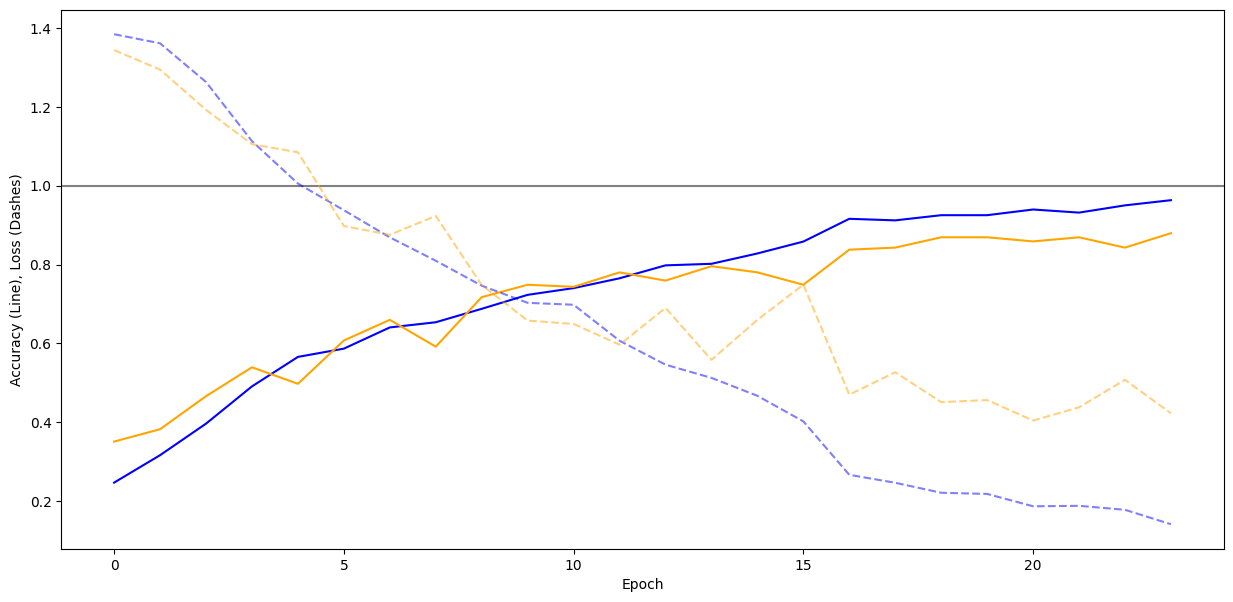

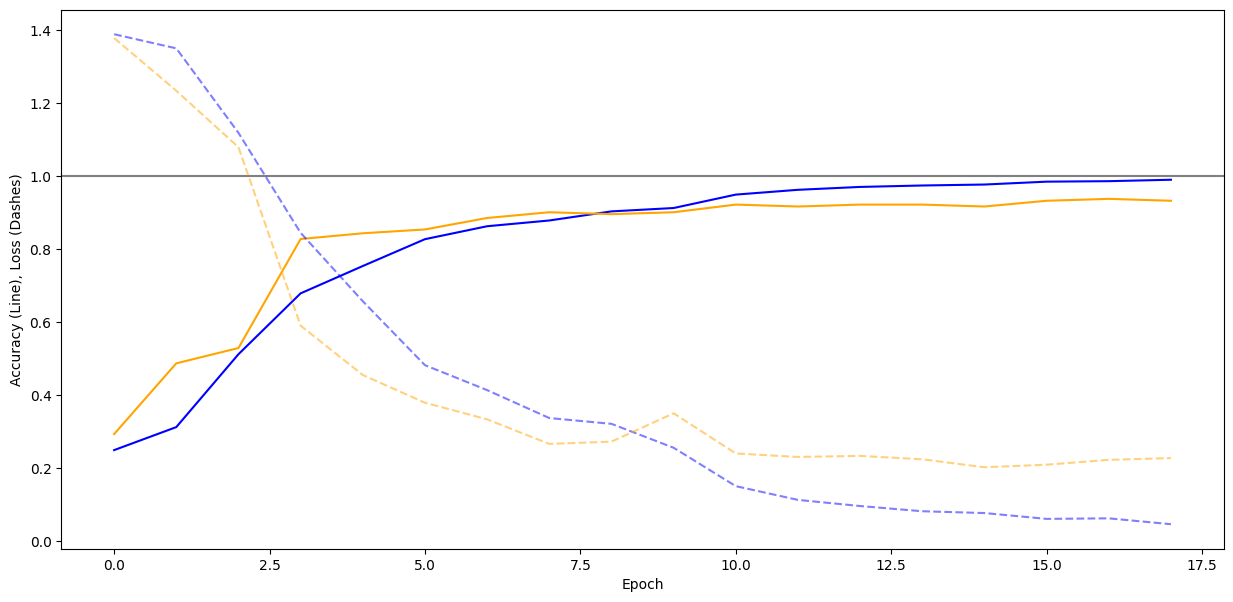

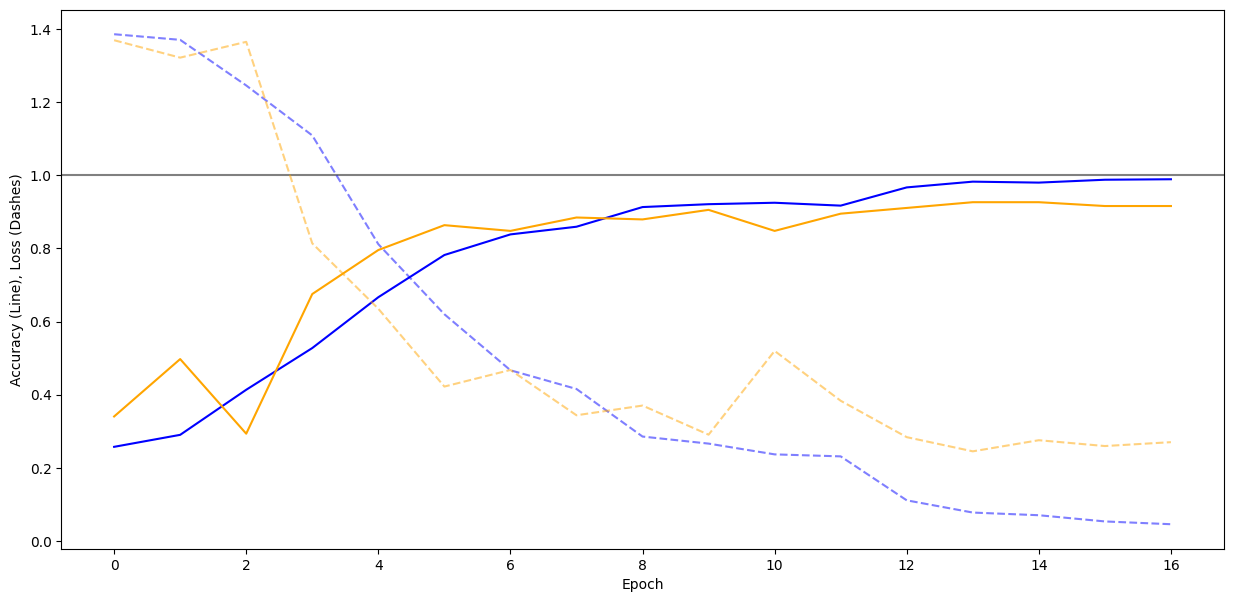

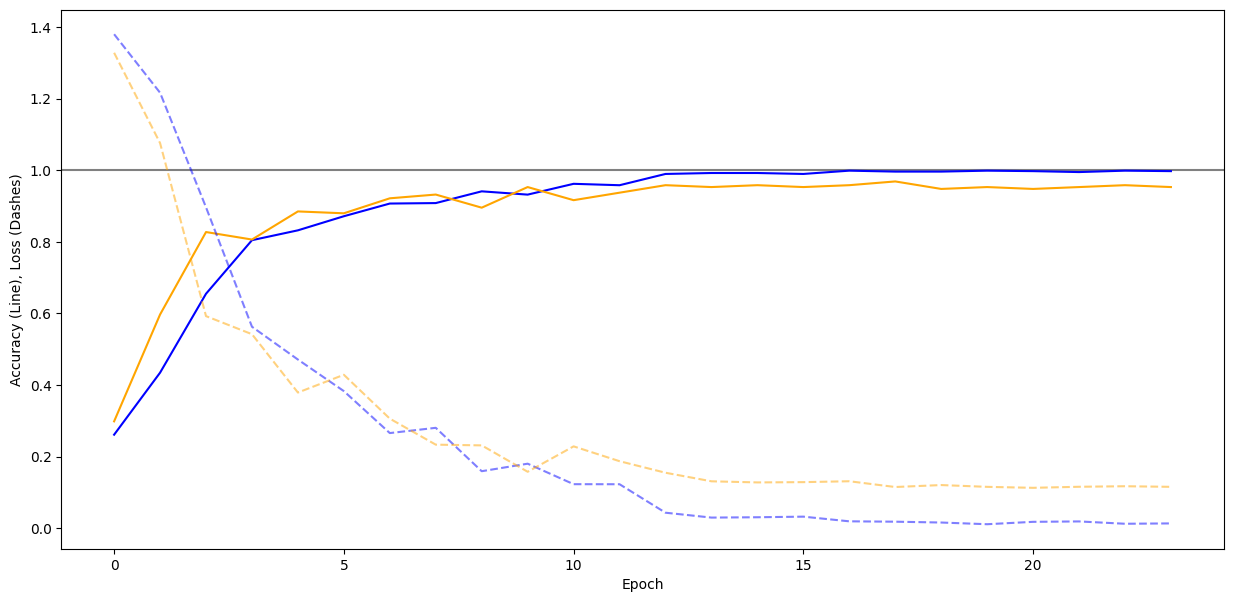

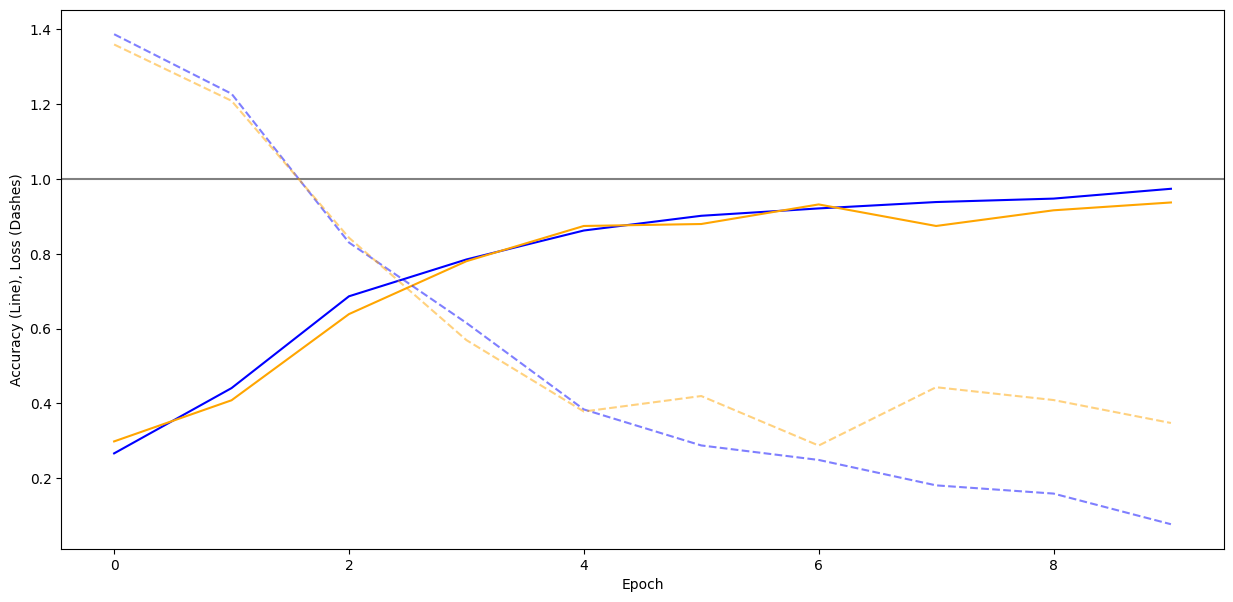

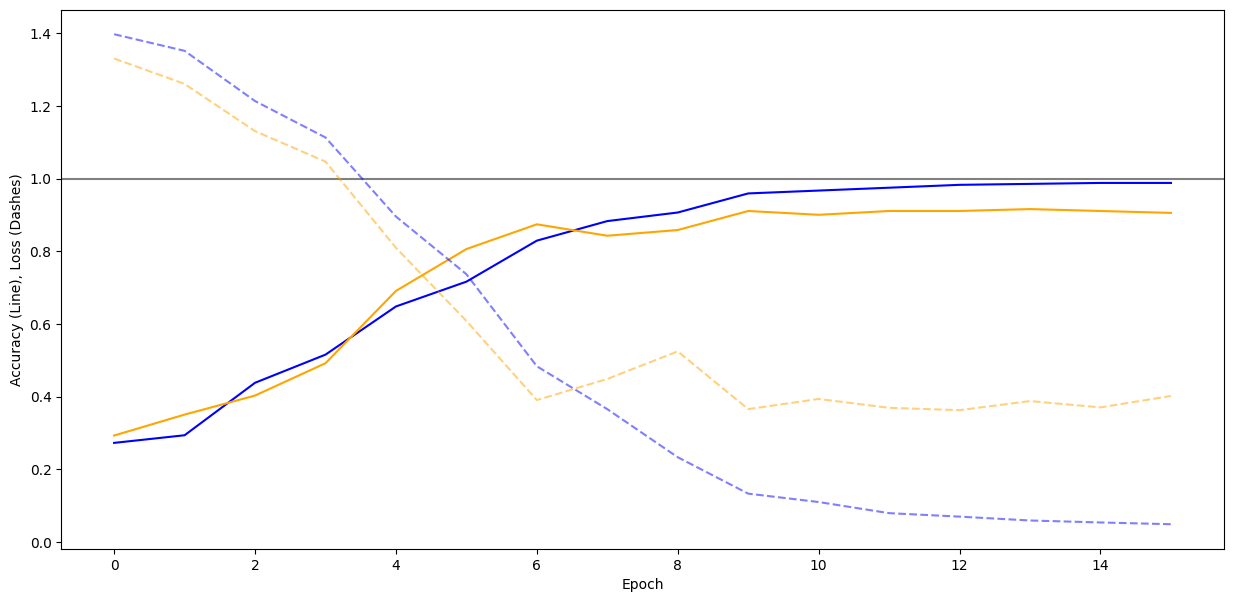

In [19]:
for history in history_for_size:
    size = history[0]
    hist = history[1]

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')
    ax.axhline(1, color='gray')
    
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    accuracy = hist.history['accuracy']
    val_accuracy = hist.history['val_accuracy']

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)
        

## Visualize results

In [20]:
import json
for history in history_for_size:
    size = history[0]
    hist = history[1]
    dictt = dict()
    dictt[size] = hist
    with open(f'{size}.json', 'w') as fp:
        json.dump(dictt, fp)



TypeError: Object of type History is not JSON serializable